# [E-10] Portrait mode

# 목차

# 루브릭

1. 인물모드 사진을 성공적으로 제작하였다.

	기준: 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
    

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

	기준: 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
    

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.


	기준: 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

# Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다. 

인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다. 

배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [5]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
# 데이터 불러오기 
import os
img_path = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/images/myimg.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

    DeepLab 모델 준비
    사전 학습 가중치 불러오기
    마스크 만들기
    세그멘테이션 결과 원복
    인물 사진 잘라내기
    배경 흐릿하게 만들기
    흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기

# DeepLab 모델
deeplab 이라는 세그멘테이션 모델을 만들고 모델에 이미지 입력!

In [ ]:
# DeepLab 모델 준비
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph() #graph 는 노드로 연결된 객체의 집합
        graph_def = None
        tar_file = tarfile.open(tarball_path) 
        for tar_info in tar_file.getmembers(): #파일에 있는 정보를 반복해서 반환한다.
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name): #tar info.name이 frozen graph name과 같은 이름이면 
                file_handle = tar_file.extractfile(tar_info) # 파일을 추출해서 file handle에 넣고 
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read()) # 파일을 읽어서 가중치를 사용한다.
                break
        tar_file.close()

        with self.graph.as_default(): #그래프의 기본값 
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph) 

    #이미지 전처리 (원본 크기 조절, grb로 변경)
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2] #height [0], width[1] 
        # inputsize = 513, max(w,h)는 둘중 큰 값을 선정 = 0.86
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) 
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
         # 세그멘테이션 함수
    def run(self, image):
         img_input = self.preprocess(image) 
        # 전처리한 함수를 입력이미지에 넣는다. 
        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
         batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,
                                       feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
# 세그멘테이션 예측:[이미지 input tensor: 전처리한 입력 img]
# 전처리한 이미지에 숫자를 매기고 이걸로 세그멘테이션 예측을 진행
         seg_map = batch_seg_map[0] #resize한 이미지의 높이 = 이미지를 라벨
         return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
height, width = img_orig.shape[:2] # 세로값, 가로값
resize_ratio = 1.0 * 513 / max(width, height)
target_size = (int(resize_ratio * width), int(resize_ratio * height))
print(height,width)
print(target_size)
print(resize_ratio)

# 사전에 학습된 가중치 불러오기
구글에서 제공하는 가중치를 다운받고 deeplabmodel을 초기화한다. 

In [ ]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

# 준비한 이미지를 네트워크에 입력

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) #15= 사람

In [ ]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

# 사람라벨만 뽑아내기
np.where 함수(seg_map==15,15,0)
=seg_map에 사람이면 사람으로 놓고 아니면 (0)으로 둬라

addWeighted 함수
(1번째 영상, 1번째영상가중치, 2번째 영상, 2번째 영상가중치, 결과영상에 더할 값)
사람이미지,사람이미지 가중치 ,컬러 마스크,컬러마스크 가중치 ,감마(밝기 정도) 0 검정- 255 흰색

In [ ]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 결과를 원래 크기로 복원하기

#### 이미지 크기를 키우때 interpolation(보간)을 고려해야한다. 

보간은 이미지 크기를 변경할때 빈공간에 픽셀값을 채우는 방법이다.

cv2.resize(입력값, 원본크기, 보간법)

#### cv2.threshold(img,threashold_value,value,flag)
thresehold = 문턱. 문턱값은 이 값을 기준으로 값이 변한다는 의미다.

문턱값 0.5를 기준으로 작으면 0, 크면 1이라고 할때 사용한다. 

이미지 픽셀값이 기준값보다 크면 a값, 작으면 b값으로 하는것 

img: grayscale 이미지

threashold_value: 기준값

value: 문턱값보다 클때 적용하는 최댓값.

flag: 문턱값 적용 스타일

오늘 flag는 THRESH_BINARY 픽셀값이  value보다 크면 value, 작으면 0 으로 할당 


참고:https://m.blog.naver.com/samsjang/220504782549

In [ ]:
#resizw이미지의 크기를 원본크기로 변경한 후 경계를 명확히 하기 위해서 threshold로 사람과 배경을 구분한다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

현재 상황
* 원본 이미지를 불러와서 세그멘데이션을 위해 deeplab 모델을 사용해서 사람만 분리함
* deeplab 모델을 사용하기 위해서 inputsize가 고정되어 있기 때문에 원본이미지를 resize했다.
* 사람만 추출한 후 다시 이미지 크기를 원상복구 시킨다.

# 배경 흐리게 하기
세그멘테이션으로 배경만 추출 - 배경 blur처리하기

In [ ]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지 반전
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) #배경만 있는 이미지 얻기
plt.imshow(img_bg)
plt.show()

In [ ]:
img_bg_blur = cv2.blur(img_bg, (13,13)) #13,13 범위 내 픽셀의 평균을 출력 이미지의 픽셀값으로 한다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경과 인물 사진 합치기
#np.where 함수 해석: img mask(세그멘데이션한 이미지) 색이 255면 원본이미지 가져오고 아니면 흐릿한 배경을 가져온다. 

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 응용1) 고양이 아웃포커싱

# 응용2) 크로마키 배경 합성

In [ ]:
# 데이터 불러오기 
import os
img_path = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/images/cat2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

In [ ]:
# DeepLab 모델 준비
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph() #graph 는 노드로 연결된 객체의 집합
        graph_def = None
        tar_file = tarfile.open(tarball_path) 
        for tar_info in tar_file.getmembers(): #파일에 있는 정보를 반복해서 반환한다.
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name): #tar info.name이 frozen graph name과 같은 이름이면 
                file_handle = tar_file.extractfile(tar_info) # 파일을 추출해서 file handle에 넣고 
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read()) # 파일을 읽어서 가중치를 사용한다.
                break
        tar_file.close()

        with self.graph.as_default(): #그래프의 기본값 
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph) 

    #이미지 전처리 (원본 크기 조절, grb로 변경)
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2] #height [0], width[1] 
        # inputsize = 513, max(w,h)는 둘중 큰 값을 선정 = 0.86
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) 
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
         # 세그멘테이션 함수
    def run(self, image):
         img_input = self.preprocess(image) 
        # 전처리한 함수를 입력이미지에 넣는다. 
        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
         batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,
                                       feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
# 세그멘테이션 예측:[이미지 input tensor: 전처리한 입력 img]
# 전처리한 이미지에 숫자를 매기고 이걸로 세그멘테이션 예측을 진행
         seg_map = batch_seg_map[0] #resize한 이미지의 높이 = 이미지를 라벨
         return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
height, width = img_orig.shape[:2] # 세로값, 가로값
resize_ratio = 1.0 * 513 / max(width, height)
target_size = (int(resize_ratio * height), int(resize_ratio * width))
print(height,width)
print(target_size)
print(resize_ratio)

In [ ]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

In [ ]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

In [ ]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#resize 이미지의 크기를 원본크기로 변경한 후 경계를 명확히 하기 위해서 threshold로 사람과 배경을 구분한다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [ ]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지 반전
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) #배경만 있는 이미지 얻기
plt.imshow(img_bg)
plt.show()

In [ ]:
img_bg_blur = cv2.blur(img_bg, (13,13)) #13,13 범위 내 픽셀의 평균을 출력 이미지의 픽셀값으로 한다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

# 응용2) 크로마키 배경 합성

배경이미지에 고양이 이미지를 합성

In [6]:
#2개의 이미지 불러오기
import cv2
import os

img_path = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/images/winter.jpeg'
img_new_bg = cv2.imread(img_path) 
img_path2 = os.getenv('HOME')+'/aiffel/aiffel_exp_data/human_segmentation/images/cat2.jpg'  
cat_img = cv2.imread(img_path2) 

print (img_new_bg.shape) #배경이미지
print (cat_img.shape)    #고양이 이미지

(711, 474, 3)
(1171, 1920, 3)


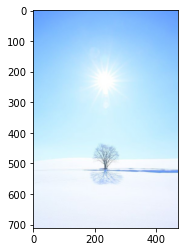

In [7]:
plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
plt.show()

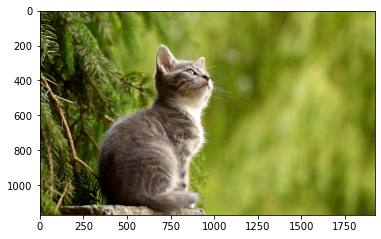

In [8]:
plt.imshow(cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB))
plt.show()

# ROI 영역 설정에서 사용할 mask 생성
이미지상에서 내가 관심있어하는 일부 영역

# Step 2. 사진에서 문제점 찾기

어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

# Step 3. 해결 방법을 제안해 보기